# **Property Price Prediction**

This dataset contains property prices and their features from various properties located in Melbourne, Australia. Examples of such features include property location, type of property and number of rooms available. This notebook will perform exploratory data analysis to find out more about Melbourne's property market, clean the data, and build a model to predict the price of a property given its features. 

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
%matplotlib inline

In [ ]:
#Importing the csv file
df = pd.read_csv('MELBOURNE_HOUSE_PRICES_LESS.csv')
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
0,Abbotsford,49 Lithgow St,3,h,1490000.0,S,Jellis,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
1,Abbotsford,59A Turner St,3,h,1220000.0,S,Marshall,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
2,Abbotsford,119B Yarra St,3,h,1420000.0,S,Nelson,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
3,Aberfeldie,68 Vida St,3,h,1515000.0,S,Barry,1/04/2017,3040,Western Metropolitan,1543,7.5,Moonee Valley City Council
4,Airport West,92 Clydesdale Rd,2,h,670000.0,S,Nelson,1/04/2017,3042,Western Metropolitan,3464,10.4,Moonee Valley City Council


# **Exploratory Data Analysis**

In [ ]:
#Exploring the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63023 entries, 0 to 63022
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         63023 non-null  object 
 1   Address        63023 non-null  object 
 2   Rooms          63023 non-null  int64  
 3   Type           63023 non-null  object 
 4   Price          48433 non-null  float64
 5   Method         63023 non-null  object 
 6   SellerG        63023 non-null  object 
 7   Date           63023 non-null  object 
 8   Postcode       63023 non-null  int64  
 9   Regionname     63023 non-null  object 
 10  Propertycount  63023 non-null  int64  
 11  Distance       63023 non-null  float64
 12  CouncilArea    63023 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 6.3+ MB


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rooms,63023.0,3.110595,0.957551,1.0,3.0,3.0,4.0,31.0
Price,48433.0,997898.241488,593498.919037,85000.0,620000.0,830000.0,1220000.0,11200000.0
Postcode,63023.0,3125.673897,125.626877,3000.0,3056.0,3107.0,3163.0,3980.0
Propertycount,63023.0,7617.728131,4424.423167,39.0,4380.0,6795.0,10412.0,21650.0
Distance,63023.0,12.684829,7.592015,0.0,7.0,11.4,16.7,64.1


## **Univariate Analysis**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


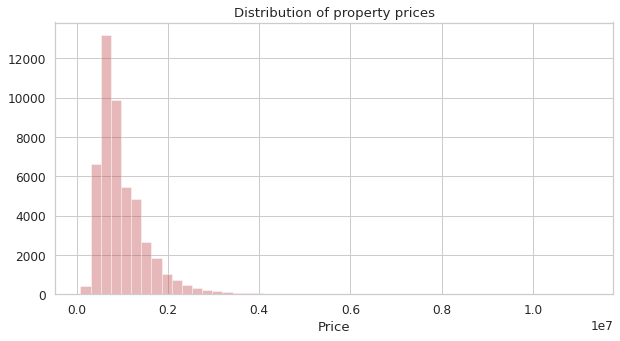

In [ ]:
#Distribution plot for Price
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc = {'figure.figsize':(10,5)})
sns.distplot(df['Price'], kde=False, color='r')
plt.title('Distribution of property prices');

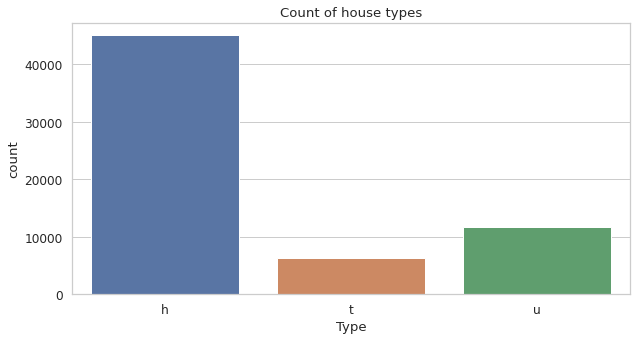

In [ ]:
#Count plot for Type
sns.countplot(x='Type', data=df)
plt.title('Count of house types');

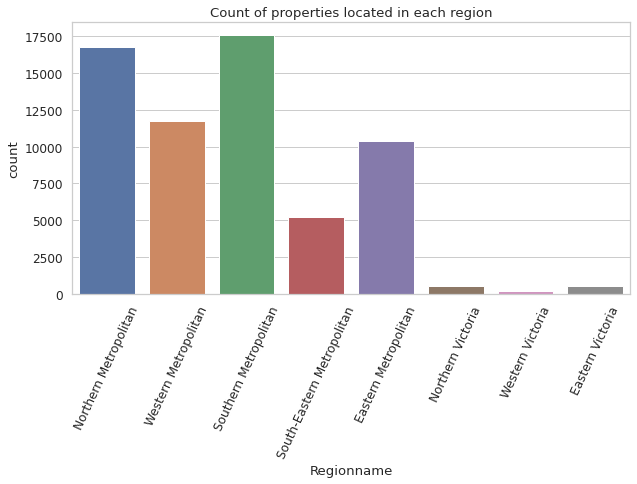

In [ ]:
#Count plot for Regionname
sns.countplot(x='Regionname', data=df)
plt.title('Count of properties located in each region')
plt.xticks(rotation=65);

From the 3 univariate plots above, a few insights can be drawn.

The Melbourne property prices in the dataset are right-skewed and normally distributed. The cheapest property costs \$85,000 while the most expensive costs \$11,200,000. The mean price for the properties is around $100,000.

A majority of the properties in the dataset are houses (house,cottage,villa,semi,terrace). Townhouses make up the least number of properties.

A majority of the properties are located in the Southern Metropolitan area while the least number of properties are located in Western Victoria. In general, the Metropolitan area holds the most number of properties compared to the Victoria area.

## **Bivariate Analysis**

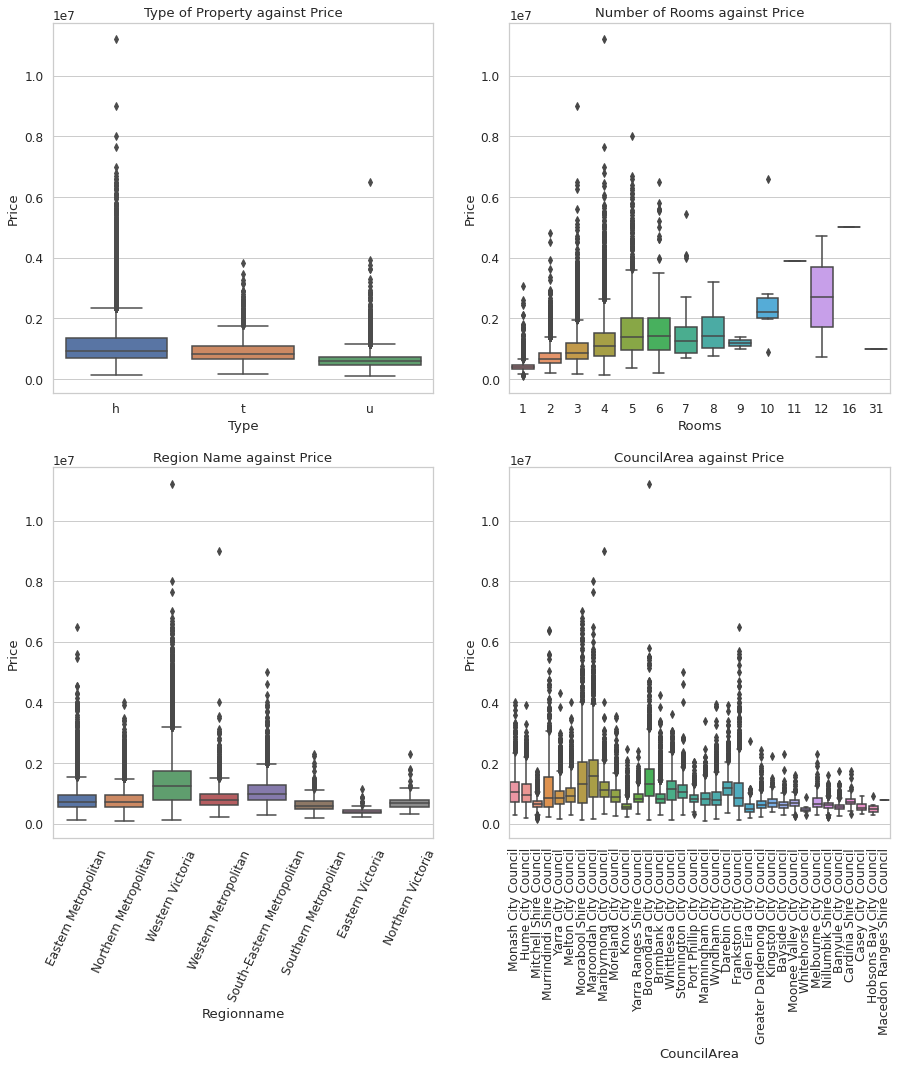

In [ ]:
fig, axes = plt.subplots(2,2, figsize = (15,15))

# Plot [0,0]
sns.boxplot(data = df, x = 'Type', y = 'Price', ax = axes[0,0])
axes[0,0].set_xlabel('Type')
axes[0,0].set_ylabel('Price')
axes[0,0].set_title('Type of Property against Price')

# Plot [0,1]
sns.boxplot(x = 'Rooms', y = 'Price', data = df, ax = axes[0,1])
axes[0,1].set_xlabel('Rooms')
axes[0,1].set_ylabel('Price')
axes[0,1].set_title('Number of Rooms against Price')

# Plot [1,0]
sns.boxplot(x = 'Regionname', y = 'Price', data = df, ax = axes[1,0])
axes[1,0].set_xlabel('Regionname')
axes[1,0].set_ylabel('Price')
axes[1,0].set_title('Region Name against Price')
axes[1,0].set_xticklabels(rotation=65, labels=list(set(df['Regionname'])))

# Plot [1,1]
sns.boxplot(x = 'CouncilArea', y = 'Price', data = df, ax = axes[1,1])
axes[1,1].set_xlabel('CouncilArea')
axes[1,1].set_ylabel('Price')
axes[1,1].set_title('CouncilArea against Price')
axes[1,1].set_xticklabels(rotation=90, labels=list(set(df['CouncilArea'])));

In the 4 boxplots above, the price label is plotted against various categorical features. It can be observed at a glance where the minimum, maximum, median, quartiles and outliers are.

For properties classified as houses, median prices are around \$1,000,000. Median prices for townhouses are slightly cheaper while units are the cheapest around $500,000. Houses have the most number of price outliers.

The prices of properties tend to generally increase with the number of rooms up to 5 rooms. From 5 rooms to 9 rooms, the median prices plateau. There is a sharp spike of prices for properties with 10 to 16 rooms.

Median prices of properties located in the Northern Victoria region are the most expensive. That region also contains the most number of price outliers, with the most expensive property valued at \$11,200,000 located there. Properties located in the Eastern Victoria region are generally the cheapest compared to the other areas.

Nilumbik Shire Council area has the highest median property price compared to the other council areas. This is closely followed by Stonnington City Council area and Banyule City Council area.

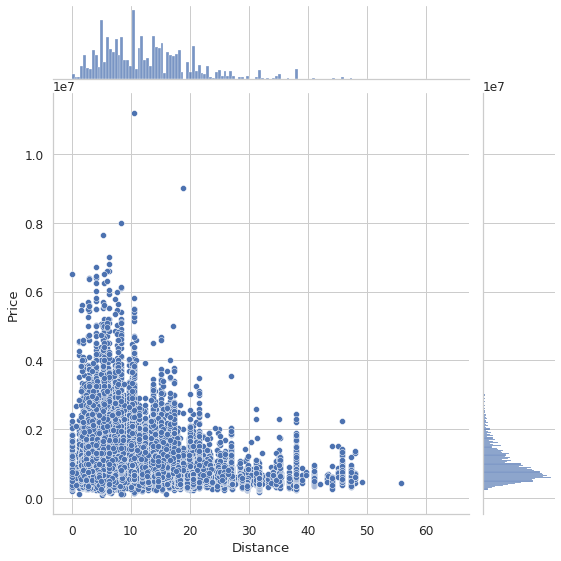

In [ ]:
sns.jointplot(x="Distance", y="Price", data=df, height=8);

In the joint plot above, the distance of the property from the Central Business District is plotted against price. Generally, price and distance are negatively correlated. The further the distance from the CBD, the cheaper the property. The extreme price outliers are all within 20km from the CBD.

# **Data Preprocessing**


This dataset contains 8 categorical features, 4 numerical features, and 1 datetime feature. The categorical and datetime features are currently of the incorrect data type. The categorical features will be changed from 'object' to 'category' while the datetime feature will be changed from 'object' to 'datetime'.

In [ ]:
#Changing the object features into categorical features
obj_feat = ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Postcode', 'Regionname', 'CouncilArea']

for col in obj_feat:
    df[col] = df[col].astype('category')

#Converting 'Date' feature to date object
df['Date'] = pd.to_datetime(df['Date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63023 entries, 0 to 63022
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Suburb         63023 non-null  category      
 1   Address        63023 non-null  category      
 2   Rooms          63023 non-null  int64         
 3   Type           63023 non-null  category      
 4   Price          48433 non-null  float64       
 5   Method         63023 non-null  category      
 6   SellerG        63023 non-null  category      
 7   Date           63023 non-null  datetime64[ns]
 8   Postcode       63023 non-null  category      
 9   Regionname     63023 non-null  category      
 10  Propertycount  63023 non-null  int64         
 11  Distance       63023 non-null  float64       
 12  CouncilArea    63023 non-null  category      
dtypes: category(8), datetime64[ns](1), float64(2), int64(2)
memory usage: 6.2 MB


The Address feature contains a mix of numbers and strings. This feature will be dropped as it negatively affects the performance of the final model. 

In [ ]:
#Dropping the 'Address' column
df = df.drop(['Address'], axis=1)

The Date feature will be split into 3 different columns by extracting the year, month and day information. The orginal Date feature is then dropped as it contains no useful information.

In [ ]:
#Creating year column
df['Year'] = df['Date'].apply(lambda x: x.year)

#Creating month column
df['Month'] = df['Date'].apply(lambda x: x.month)

#Creating day column
df['Day'] = df['Date'].apply(lambda x: x.day)

df = df.drop('Date', axis=1)

In [ ]:
df.head()

,Suburb,Rooms,Type,Price,Method,SellerG,Postcode,Regionname,Propertycount,Distance,CouncilArea,Year,Month,Day
0,Abbotsford,3,h,1490000.0,S,Jellis,3067,Northern Metropolitan,4019,3.0,Yarra City Council,2017,1,4
1,Abbotsford,3,h,1220000.0,S,Marshall,3067,Northern Metropolitan,4019,3.0,Yarra City Council,2017,1,4
2,Abbotsford,3,h,1420000.0,S,Nelson,3067,Northern Metropolitan,4019,3.0,Yarra City Council,2017,1,4
3,Aberfeldie,3,h,1515000.0,S,Barry,3040,Western Metropolitan,1543,7.5,Moonee Valley City Council,2017,1,4
4,Airport West,2,h,670000.0,S,Nelson,3042,Western Metropolitan,3464,10.4,Moonee Valley City Council,2017,1,4


Label encoding will be performed on the remaining 7 categorical features. One-hot encoding is usually the go-to method for dealing with categorical features. However in this context, there are 2 reasons for choosing label encoding. 

Firstly, there are too many categorical variables and using one-hot encoding will lead to a dateset with over 1000 dummy features which might cause overfitting. 

Secondly, a tree-based model will be fitted to the data. Tree-based models which use recursive partitioning can learn the same information from label encoded features as one-hot encoded features. Fitting a tree-based model on a dataset with 15 features will be faster than on a dataset with over 1000 features.

In [ ]:
df[['Suburb']]  = LabelEncoder().fit_transform(df['Suburb'])
df[['Type']]  = LabelEncoder().fit_transform(df['Type'])
df[['Method']]  = LabelEncoder().fit_transform(df['Method'])
df[['SellerG']]  = LabelEncoder().fit_transform(df['SellerG'])
df[['Postcode']]  = LabelEncoder().fit_transform(df['Postcode'])
df[['Regionname']]  = LabelEncoder().fit_transform(df['Regionname'])
df[['CouncilArea']]  = LabelEncoder().fit_transform(df['CouncilArea'])

In [ ]:
df.head()

,Suburb,Rooms,Type,Price,Method,SellerG,Postcode,Regionname,Propertycount,Distance,CouncilArea,Year,Month,Day
0,0,3,0,1490000.0,2,198,54,2,4019,3.0,32,2017,1,4
1,0,3,0,1220000.0,2,255,54,2,4019,3.0,32,2017,1,4
2,0,3,0,1420000.0,2,286,54,2,4019,3.0,32,2017,1,4
3,1,3,0,1515000.0,2,28,30,6,1543,7.5,22,2017,1,4
4,2,2,0,670000.0,2,286,32,6,3464,10.4,22,2017,1,4


Missing values in the Price label will need to be resolved. There are a few ways to deal with a numerical feature with missing values. 

One way is to drop the observations with missing values. There are 14,590 missing values in the Price column. The missing values constitue 23% of the total observations. Dropping them will lead to a big loss of information and reduced degrees of freedom. 

Another way is to replace with either the mean, median or mode. However, this method is univariate and does not account for the Price label's correlation with the other features. 

There is a more accurate way to do this, which is to use the KNN Imputer. This is a bivariate strategy which imputes missing values by identifying nearest neighbours through measuring the Eculidean distance. The downside is that it is computationally expensive when the number of features increases.

In [ ]:
# Initiate the KNNImputer
imputer = KNNImputer(n_neighbors=2)

df = imputer.fit_transform(df)
df = pd.DataFrame(df)

In [ ]:
#Renaming column names back to original
df.rename(columns={0: 'Suburb', 1: 'Rooms', 2: 'Type', 3: 'Price', 4: 'Method', 5: 'SellerG', 6: 'Postcode', 7: 'Regionname', 8: 'Propertycount', 9: 'Distance', 10: 'CouncilArea', 11: 'Year', 12: 'Month', 13: 'Day'}, inplace=True)

In [ ]:
df.isnull().sum().sum()

0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63023 entries, 0 to 63022
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         63023 non-null  float64
 1   Rooms          63023 non-null  float64
 2   Type           63023 non-null  float64
 3   Price          63023 non-null  float64
 4   Method         63023 non-null  float64
 5   SellerG        63023 non-null  float64
 6   Postcode       63023 non-null  float64
 7   Regionname     63023 non-null  float64
 8   Propertycount  63023 non-null  float64
 9   Distance       63023 non-null  float64
 10  CouncilArea    63023 non-null  float64
 11  Year           63023 non-null  float64
 12  Month          63023 non-null  float64
 13  Day            63023 non-null  float64
dtypes: float64(14)
memory usage: 6.7 MB


# **Model Building**

For the model building phase, the dataset will be split into the training and testing sets.

A XGBoost Regressor will be fitted to the training data as a baseline model. XGBoost is a tree-based gradient boosting ensemble algorithm. Thus, no scaling is required for tree-based models .

Hyperparameter tuning with Grid Search Cross Validation will then be performed on the model. The model with the best parameters will be the final model used on the testing data.

In [ ]:
X = df.drop('Price', axis=1)
y = df['Price']

In [ ]:
#Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 10)

In [ ]:
#Initiate the XGBoost Regressor
xgbr = xgb.XGBRegressor()

#Fitting the xgboost baseline model
xgbr.fit(X_train, y_train)

[09:43:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
#Parameters of the xgboost baseline model
xgbr.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [ ]:
#Training R2 Score for base XGboost Regressor (Untuned)
y_train_pred = xgbr.predict(X_train)
print('Training R2 score for untuned model: ', r2_score(y_train, y_train_pred)*100,'%')

#Training RSMSE for base XGboost Regressor (Untuned)
MSE = mse(y_train_pred, y_train)
RMSE = np.sqrt(MSE)
print('Training RMSE for untuned model: %.4f' % RMSE)

Training R2 score for untuned model:  64.91914207474596 %
Training RMSE for untuned model: 354996.2265


In [ ]:
#Hyper parameter tuning for XGBRegressor
xgb_param_grid = {
  'objective': ['reg:squarederror', 'reg:tweedie', 'reg:linear'],
  'learning_rate' : [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
  'max_depth' : [3, 5, 7, 10, 15],
  'n_estimators' : [100, 200, 300, 400, 500]
  }

#Hyper parameter tuning for XGBRegressor
model = RandomizedSearchCV(estimator=xgbr, param_distributions=xgb_param_grid, cv=5, scoring= 'r2', n_iter=15, verbose=1, n_jobs = -1)

model.fit(X_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_iter=15, n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 5, 7, 10, 15],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'objective': ['reg:squarederror',
                                                      'reg:tweedie',
                                                      'reg:linear']},
                   scoring='r2', verbose=1)

In [ ]:
print('Best parameters are: ', model.best_params_)

Best parameters are:  {'objective': 'reg:tweedie', 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.1}


In [ ]:
#Training R2 Score for tuned model
print('Training R2 for Tuned Model: %.4f' % (model.score(X_train, y_train)*100),'%')

#Training RMSE for tuned model
y_train_pred_tuned = model.predict(X_train)
MSE = mse(y_train_pred_tuned, y_train)
RMSE = np.sqrt(MSE)
print('Training RMSE for Tuned Model: %.4f' % RMSE)

Training R2 for Tuned Model: 74.7569 %
Training RMSE for Tuned Model: 301134.0216


In [ ]:
#Testing R2 Score for tuned model
print('The final R2 on the testing set is: %.4f' % (model.score(X_test, y_test)*100),'%')

#Testing RMSE for tuned model
final_model = model.best_estimator_
final_pred = final_model.predict(X_test)
final_mse = mse(y_test, final_pred)
final_rmse = np.sqrt(final_mse)
print('The final RMSE on the test set is', round(final_rmse, 2))

The final R2 on the testing set is: 69.4880 %
The final RMSE on the test set is 328154.83


# **Evaluation**

The base XGBoost Regressor model achieved a R2 score of 64.92% and RMSE of $354,996.23 on the training data.

After tuning, the tuned XGBoost Regressor model achieved a R2 score of 74.76% and RMSE of $301,134.02 on the training data. 

Finally, the tuned XGBoost Regressor model achieved a R2 score of 69.45% and RMSE of $328,154.83 on the testing data. The final model is able to account for 69.45% of the variation in testing data. 

There are some possible future improvements to this project. The address column could be tokenized which would preserve more information than dropping the column. Also, the categorical features could be one-hot encoded and a neural network model tested on the resulting dataset.  